In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, round, max, desc


In [2]:
spark = SparkSession.builder.appName("PassportSeva_1_1").getOrCreate()

In [3]:
df = spark.read.csv("PassportSeva_1_1.csv", header = True, inferSchema=True)

In [4]:
print("=== Services Name and Type ===")

df.show()

=== Services Name and Type ===
+--------------------+-------------+--------------------+-------------+--------------+------------+--------------------+
|         ServiceName|      RpoName|          SchemeType|LastWeekCount|LastMonthCount|YearTillDate|                Date|
+--------------------+-------------+--------------------+-------------+--------------+------------+--------------------+
|Applications Rece...|RPO Ahmedabad|              Normal|         7174|         51414|      567081|2019-11-03 04:29:...|
|Applications Rece...|RPO Ahmedabad|             Tatkaal|          160|          1368|       14930|2019-11-03 04:29:...|
|Applications Rece...|RPO Ahmedabad|              FEMALE|         3029|         21273|      233635|2019-11-03 04:29:...|
|Applications Rece...|RPO Ahmedabad|                MALE|         4305|         31498|      348282|2019-11-03 04:29:...|
|Applications Rece...|RPO Ahmedabad|         TRANSGENDER|            0|             1|          15|2019-11-03 04:29:...|
|

In [5]:
print("=== Schema Representation ===")

df.printSchema()

=== Schema Representation ===
root
 |-- ServiceName: string (nullable = true)
 |-- RpoName: string (nullable = true)
 |-- SchemeType: string (nullable = true)
 |-- LastWeekCount: integer (nullable = true)
 |-- LastMonthCount: integer (nullable = true)
 |-- YearTillDate: integer (nullable = true)
 |-- Date: timestamp (nullable = true)



In [6]:
df.describe(["LastWeekCount", "LastMonthCount", "YearTillDate"]).show()

+-------+------------------+------------------+--------------------+
|summary|     LastWeekCount|    LastMonthCount|        YearTillDate|
+-------+------------------+------------------+--------------------+
|  count|               925|               925|                 925|
|   mean|253514.60216216216|1123856.6281081082|1.1942464032432433E7|
| stddev|1157869.6538211717| 5101417.563461397|5.4668622355825864E7|
|    min|                 0|                 0|                   0|
|    max|          12291000|          58278750|           651091300|
+-------+------------------+------------------+--------------------+



In [7]:
df.count()

925

In [8]:
from pyspark.sql.functions import sum

print("=== Applications city wise ===")

df.groupBy("RpoName") \
  .agg(sum("LastWeekCount").alias("Total_Weekly_count_of_Application"),
       sum("LastMonthCount").alias("Total_Monthly_count_of_Applications"),
       sum("YearTillDate").alias("Total_YTD")) \
  .orderBy("Total_YTD", ascending=False) \
.show(10)


=== Applications city wise ===
+--------------+---------------------------------+-----------------------------------+---------+
|       RpoName|Total_Weekly_count_of_Application|Total_Monthly_count_of_Applications|Total_YTD|
+--------------+---------------------------------+-----------------------------------+---------+
|    RPO Mumbai|                         15303086|                           73627268|836185050|
| RPO Ahmedabad|                          8669776|                           59849072|715869181|
|RPO Chandigarh|                         12462621|                           54893015|712278605|
|   RPO Kolkata|                         14320998|                           67058288|704890308|
|     RPO Delhi|                         12112108|                           54663456|690943097|
|   RPO Lucknow|                         12949638|                           68214077|664248567|
| RPO Hyderabad|                         11847045|                           56521342|561867650|

In [9]:
print("=== Top 5 cities with most number of applications ===")

df.groupBy("RpoName") \
    .agg(sum("YearTillDate").alias("Total_Number_of_Application_Till_Date")) \
    .orderBy("Total_Number_of_Application_Till_Date",ascending = False) \
    .show(5)

=== Top 5 cities with most number of applications ===
+--------------+-------------------------------------+
|       RpoName|Total_Number_of_Application_Till_Date|
+--------------+-------------------------------------+
|    RPO Mumbai|                            836185050|
| RPO Ahmedabad|                            715869181|
|RPO Chandigarh|                            712278605|
|   RPO Kolkata|                            704890308|
|     RPO Delhi|                            690943097|
+--------------+-------------------------------------+
only showing top 5 rows



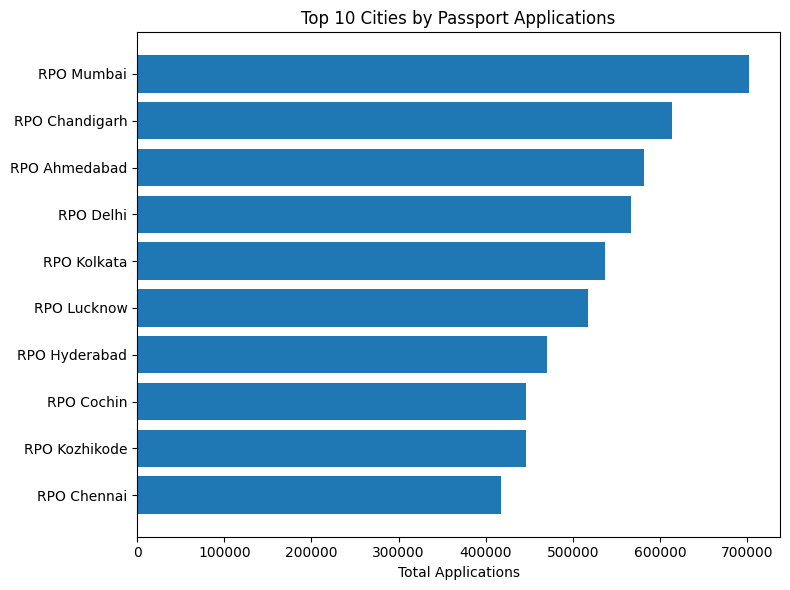

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
def spark_to_pandas(spark_df, limit=1000):
    return spark_df.limit(limit).toPandas()
    
top_cities = df.filter(col("ServiceName") == "Applications Received - Scheme wise") \
    .groupBy("RpoName") \
    .agg(sum("YearTillDate").alias("TotalApplications")) \
    .orderBy(desc("TotalApplications")) \
    .limit(10)

top_cities_pd = spark_to_pandas(top_cities)

plt.figure(figsize=(8, 6))
plt.barh(top_cities_pd['RpoName'], top_cities_pd['TotalApplications'])
plt.xlabel('Total Applications')
plt.title('Top 10 Cities by Passport Applications')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [11]:
print("=== Gender wise applications ===")

gender_df = df.filter(df.ServiceName.contains("Gender wise"))
gender_df.groupBy("SchemeType") \
    .agg(sum("YearTillDate").alias("Total_Applicants")) \
    .filter(gender_df.SchemeType.isin("MALE", "FEMALE", "TRANSGENDER")) \
    .show()


=== Gender wise applications ===
+-----------+----------------+
| SchemeType|Total_Applicants|
+-----------+----------------+
|       MALE|         5768290|
|     FEMALE|         3278088|
|TRANSGENDER|             332|
+-----------+----------------+



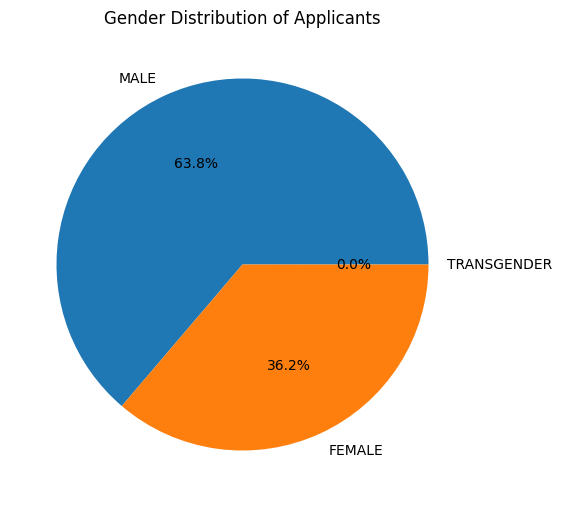

In [12]:
gender_dist = df.filter(col("ServiceName") == "Applications Received - Gender wise") \
    .groupBy("SchemeType") \
    .agg(sum("YearTillDate").alias("Count"))

gender_pd = spark_to_pandas(gender_dist)

plt.figure(figsize=(6, 8))
plt.pie(gender_pd['Count'], labels=gender_pd['SchemeType'], autopct='%1.1f%%')
plt.title('Gender Distribution of Applicants')
plt.show()

In [13]:
print("=== Gender wise applicants from Hyderabad ===")

city = "RPO Hyderabad"

df_city = df.filter((col("RpoName") == city)&(col("ServiceName").contains("Gender wise")))
df_city.groupBy("SchemeType") \
    .agg(sum("YearTillDate").alias("Total_Applicants_from_Hyderabad")) \
    .filter(col("SchemeType").isin("MALE", "FEMALE", "TRANSGENDER")) \
    .show()


=== Gender wise applicants from Hyderabad ===
+-----------+-------------------------------+
| SchemeType|Total_Applicants_from_Hyderabad|
+-----------+-------------------------------+
|       MALE|                         287793|
|     FEMALE|                         182816|
|TRANSGENDER|                             12|
+-----------+-------------------------------+



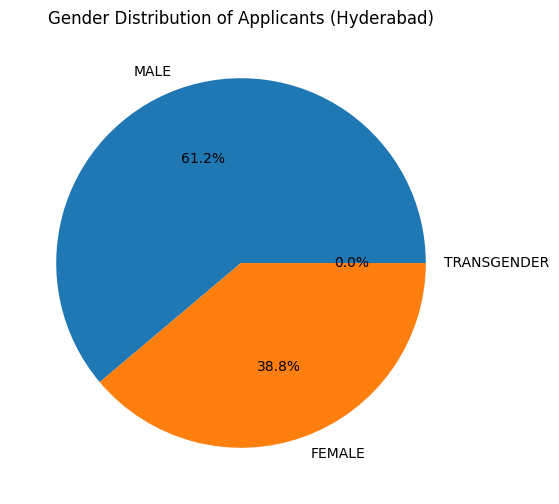

In [14]:
gender_dist = df.filter((col("ServiceName") == "Applications Received - Gender wise")&(col("RpoName") == city)) \
    .groupBy("SchemeType") \
    .agg(sum("YearTillDate").alias("Count"))

gender_pd = spark_to_pandas(gender_dist)

plt.figure(figsize=(6, 6))
plt.pie(gender_pd['Count'], labels=gender_pd['SchemeType'], autopct='%1.1f%%')
plt.title('Gender Distribution of Applicants (Hyderabad)')
plt.show()

In [15]:
print("=== Count of Female Applicants (Top to Low) ===")

female_applicants = df \
        .filter(col("ServiceName") == "Applications Received - Gender wise") \
        .filter(col("SchemeType") == "FEMALE") \
        .groupBy("RpoName") \
        .agg(
            sum("LastWeekCount").alias("Last Week Female Count"),
            sum("LastMonthCount").alias("Last Month Female Count"),
            sum("YearTillDate").alias("Year To Date Female Count")
        ) \
        .orderBy(desc("Year To Date Female Count"))
female_applicants.show()

=== Count of Female Applicants (Top to Low) ===
+--------------+----------------------+-----------------------+-------------------------+
|       RpoName|Last Week Female Count|Last Month Female Count|Year To Date Female Count|
+--------------+----------------------+-----------------------+-------------------------+
|    RPO Mumbai|                  6169|                  26946|                   301535|
|RPO Chandigarh|                  4281|                  21741|                   240137|
| RPO Ahmedabad|                  3029|                  21273|                   233635|
|     RPO Delhi|                  3840|                  18253|                   228179|
|    RPO Cochin|                  4527|                  20414|                   195651|
| RPO Kozhikode|                  5002|                  21063|                   190445|
| RPO Hyderabad|                  3921|                  18916|                   182816|
|   RPO Kolkata|                  4351|             

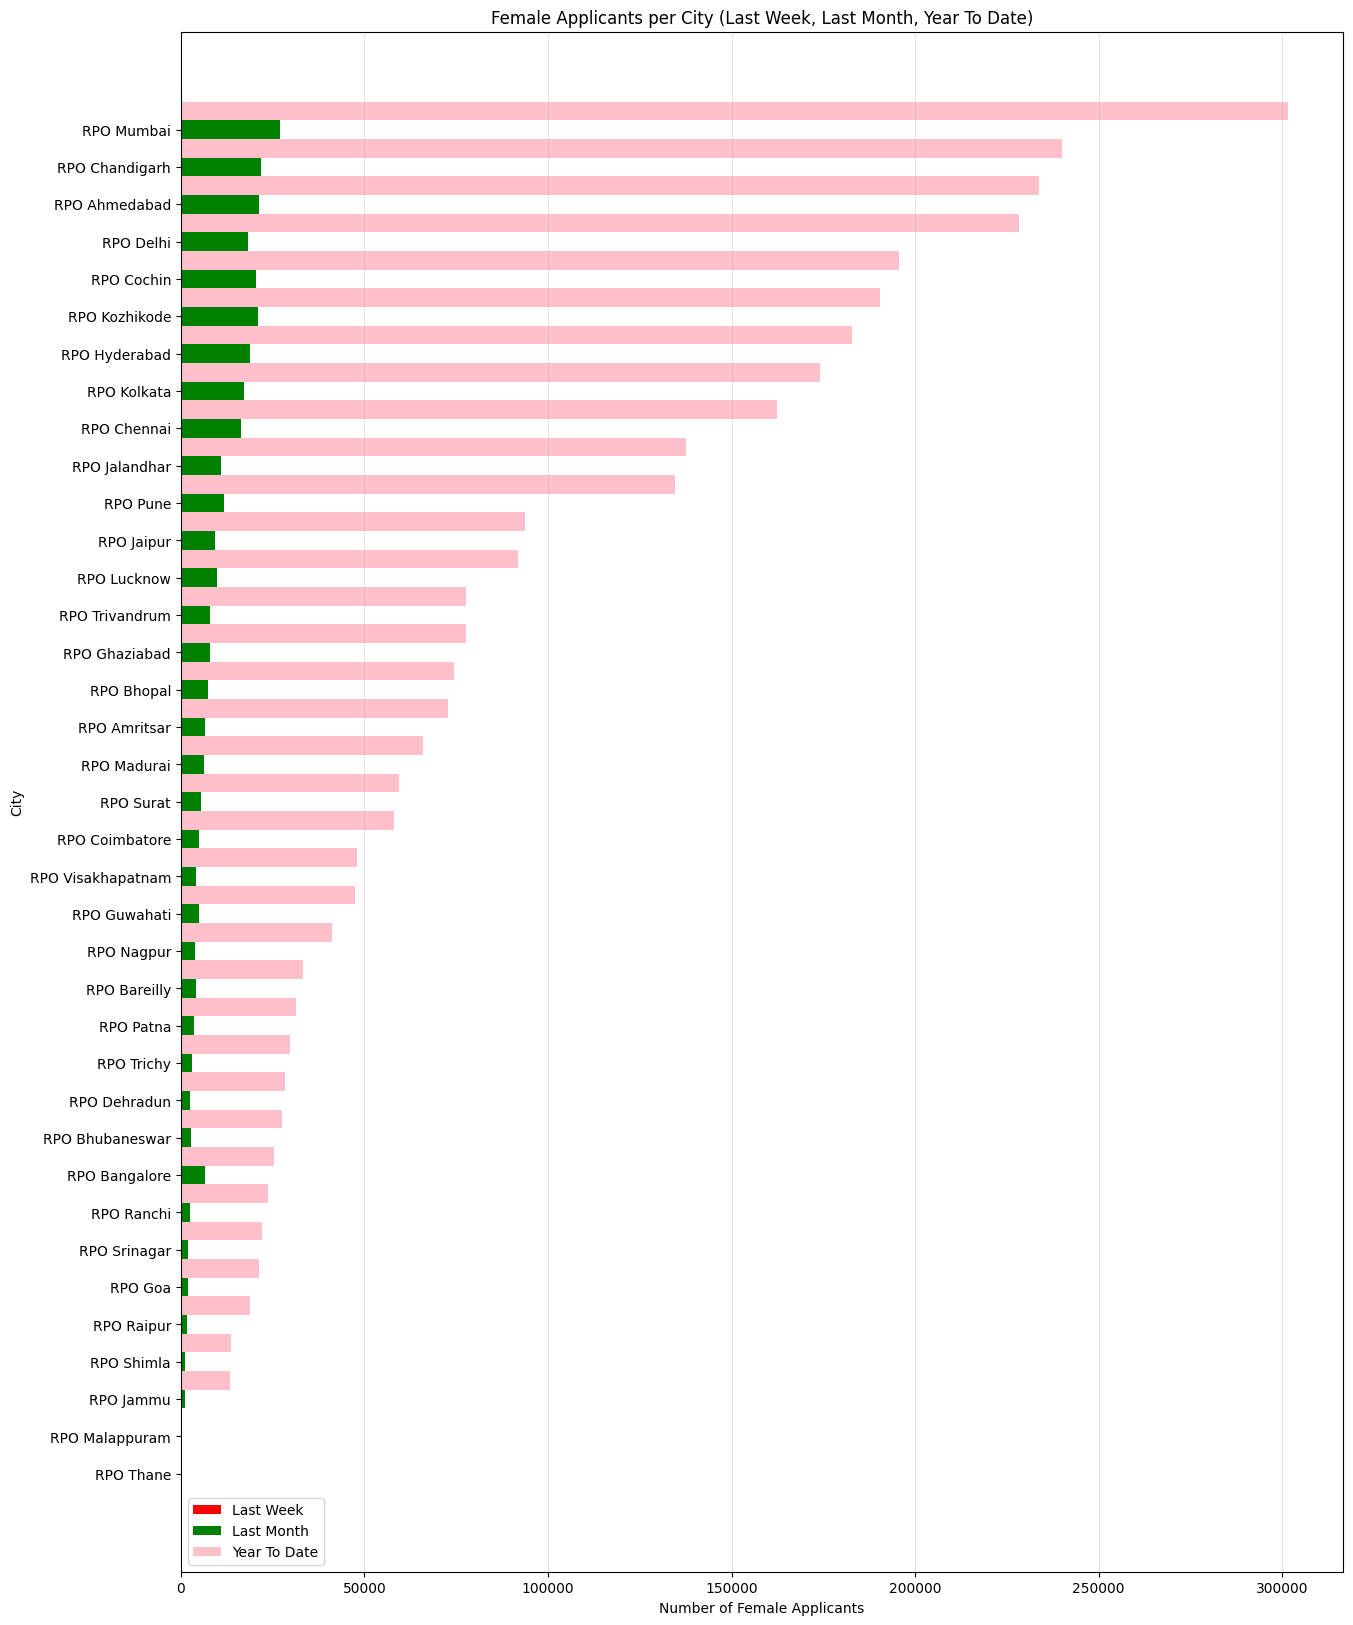

In [120]:
female_applicants_pd = female_applicants.toPandas()

female_applicants_pd = female_applicants_pd.sort_values('Year To Date Female Count', ascending=True)

cities = female_applicants_pd['RpoName']
y_pos = np.arange(len(cities))
bar_width = 0.5

plt.figure(figsize=(15, 20))

plt.barh(y_pos - bar_width, female_applicants_pd['Last Week Female Count'], height=bar_width, label='Last Week', color='red')
plt.barh(y_pos, female_applicants_pd['Last Month Female Count'], height=bar_width, label='Last Month', color='green')
plt.barh(y_pos + bar_width, female_applicants_pd['Year To Date Female Count'], height=bar_width, label='Year To Date', color='pink')

plt.yticks(y_pos, cities)
plt.xlabel('Number of Female Applicants')
plt.ylabel('City')
plt.title('Female Applicants per City (Last Week, Last Month, Year To Date)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.show()

In [16]:
print("=== Application Types ===")

scheme_comparison = df.filter(df.ServiceName.contains("Scheme wise")) \
    .groupBy("SchemeType") \
    .agg(sum("YearTillDate").alias("TotalApplications")) \
    .orderBy(desc("TotalApplications"))

scheme_comparison.show()

=== Application Types ===
+----------+-----------------+
|SchemeType|TotalApplications|
+----------+-----------------+
|    Normal|          8723190|
|   Tatkaal|           324196|
+----------+-----------------+



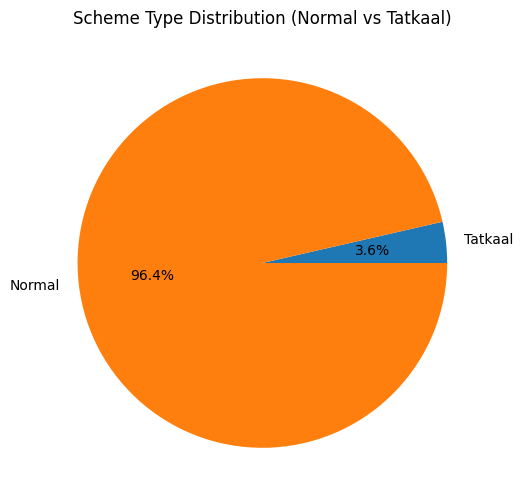

In [17]:
scheme_dist = df.filter(col("ServiceName") == "Applications Received - Scheme wise") \
    .groupBy("SchemeType") \
    .agg(sum("YearTillDate").alias("Count"))

scheme_pd = spark_to_pandas(scheme_dist)

plt.figure(figsize=(6, 6))
plt.pie(scheme_pd['Count'], labels=scheme_pd['SchemeType'], autopct='%1.1f%%')
plt.title('Scheme Type Distribution (Normal vs Tatkaal)')
plt.show()

In [18]:
print("=== Payment Type Destribution ===")

payment_mode = df.filter(col("ServiceName") == "Application Fee Online Payment - Mode Wise") \
    .groupBy("SchemeType") \
    .agg(sum("YearTillDate").alias("TotalAmount")) \
    .orderBy(desc("TotalAmount")) \

payment_mode.show()

=== Payment Type Destribution ===
+------------------+-----------+
|        SchemeType|TotalAmount|
+------------------+-----------+
|Credit/ Debit Card| 6435851550|
|            Online| 4294884100|
|           Challan|  250364550|
+------------------+-----------+



=== Payment Type Destribution ===


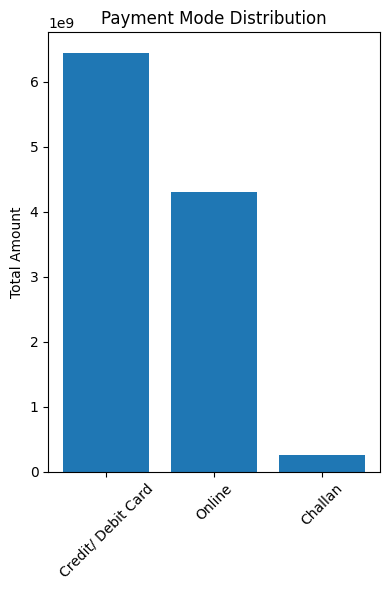

In [19]:
print("=== Payment Type Destribution ===")

payment_modes = df.filter(col("ServiceName") == "Application Fee Online Payment - Mode Wise") \
    .groupBy("SchemeType") \
    .agg(sum("YearTillDate").alias("TotalAmount")) \
    .orderBy(desc("TotalAmount"))

payment_pd = spark_to_pandas(payment_modes)

plt.figure(figsize=(4, 6))
plt.bar(payment_pd['SchemeType'], payment_pd['TotalAmount'])
plt.xticks(rotation=45)
plt.ylabel('Total Amount')
plt.title('Payment Mode Distribution')
plt.tight_layout()
plt.show()

In [20]:
print("=== Application Type Hyderabad ===")

scheme_comparison = df.filter((df.ServiceName.contains("Scheme wise"))&(df.RpoName == city)) \
    .groupBy("SchemeType") \
    .agg(sum("YearTillDate").alias("Total_Applications_Hyderabad")) \
    .orderBy(desc("Total_Applications_Hyderabad"))

scheme_comparison.show()

=== Application Type Hyderabad ===
+----------+----------------------------+
|SchemeType|Total_Applications_Hyderabad|
+----------+----------------------------+
|    Normal|                      455010|
|   Tatkaal|                       15714|
+----------+----------------------------+



In [21]:
print("=== Payment Mode Destribution ===")

payment_mode_df = df.filter((col("ServiceName") == "Application Fee Online Payment - Mode Wise")&(df.RpoName == city)) \
    .groupBy("SchemeType") \
    .agg(sum("YearTillDate").alias("TotalAmount")) \
    .orderBy(desc("TotalAmount")) \

payment_mode_df.show()


=== Payment Mode Destribution ===
+------------------+-----------+
|        SchemeType|TotalAmount|
+------------------+-----------+
|Credit/ Debit Card|  313582500|
|            Online|  240724300|
|           Challan|    4153750|
+------------------+-----------+



=== Payment Mode Destribution Graph ===


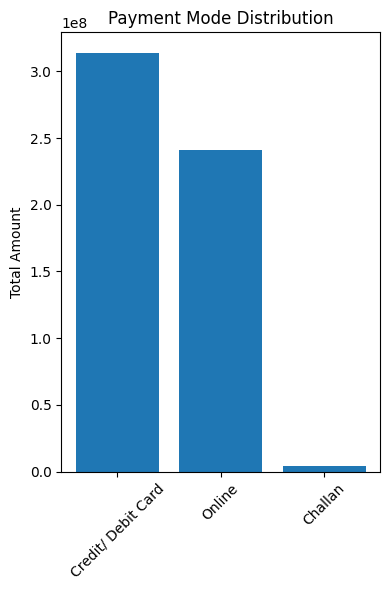

In [22]:
print("=== Payment Mode Destribution Graph ===")

payment_modes = df.filter((col("ServiceName") == "Application Fee Online Payment - Mode Wise")&(df.RpoName == city)) \
    .groupBy("SchemeType") \
    .agg(sum("YearTillDate").alias("TotalAmount")) \
    .orderBy(desc("TotalAmount"))

payment_pd = spark_to_pandas(payment_modes)

plt.figure(figsize=(4, 6))
plt.bar(payment_pd['SchemeType'], payment_pd['TotalAmount'])
plt.xticks(rotation=45)
plt.ylabel('Total Amount')
plt.title('Payment Mode Distribution')
plt.tight_layout()
plt.show()

In [23]:
print("=== Edudation Qualification of Applicants ===")

education_df = df.filter(df.ServiceName.contains("Education Wise")) \
    .groupBy("SchemeType") \
    .agg(sum("YearTillDate").alias("TotalApplications")) \
    .orderBy(desc("TotalApplications"))

education_df.show()

=== Edudation Qualification of Applicants ===
+--------------------+-----------------+
|          SchemeType|TotalApplications|
+--------------------+-----------------+
| 10TH PASS AND ABOVE|          3301389|
|  GRADUATE AND ABOVE|          2621794|
|BETWEEN 6TH AND 9...|            38233|
|    5TH PASS OR LESS|            33944|
+--------------------+-----------------+



In [24]:
print("=== Edudation Qualification of Hyderabad Applicants ===")

city = "RPO Hyderabad"

education_df = df.filter((df.ServiceName.contains("Education Wise"))& (df.RpoName == city)) \
    .groupBy("SchemeType") \
    .agg(sum("YearTillDate").alias("Total_Applications_Hyderabad")) \
    .orderBy(desc("Total_Applications_Hyderabad"))

education_df.show()

=== Edudation Qualification of Hyderabad Applicants ===
+--------------------+----------------------------+
|          SchemeType|Total_Applications_Hyderabad|
+--------------------+----------------------------+
|  GRADUATE AND ABOVE|                      157847|
| 10TH PASS AND ABOVE|                      152407|
|BETWEEN 6TH AND 9...|                           0|
|    5TH PASS OR LESS|                           0|
+--------------------+----------------------------+



In [25]:
print("=== Verification Time ===")

pv_time = df.filter(col("ServiceName") == "PV Processing Time") \
    .groupBy("SchemeType") \
    .agg(sum("YearTillDate").alias("TotalCases")) \
    .orderBy(desc("TotalCases"))

pv_time.show()

=== Verification Time ===
+-----------------+----------+
|       SchemeType|TotalCases|
+-----------------+----------+
|   Within 21 Days|   5412490|
|More than 21 Days|   1049175|
+-----------------+----------+



In [26]:
pv_analysis = df.filter((col("ServiceName") == "PV Processing Time")&(df.RpoName == city)) \
    .groupBy("SchemeType") \
    .agg(sum("YearTillDate").alias("TotalCases_Hyderabad")) \
    .orderBy(desc("TotalCases_Hyderabad"))

pv_analysis.show()

+-----------------+--------------------+
|       SchemeType|TotalCases_Hyderabad|
+-----------------+--------------------+
|   Within 21 Days|              289615|
|More than 21 Days|                 997|
+-----------------+--------------------+



In [27]:
print("=== Verification types ===")

pv_verification_mode = df.filter(col("ServiceName") == "Applications Granted - PV Mode wise") \
    .groupBy("SchemeType") \
    .agg(
        sum("LastWeekCount").alias("LastWeekGrants"),
        sum("LastMonthCount").alias("LastMonthGrants"),
        sum("YearTillDate").alias("YTD_Grants")
    ) \
    .orderBy(desc("YTD_Grants"))

pv_verification_mode.show(truncate = False)

=== Verification types ===
+-----------------+--------------+---------------+----------+
|SchemeType       |LastWeekGrants|LastMonthGrants|YTD_Grants|
+-----------------+--------------+---------------+----------+
|Pre Verification |122326        |558352         |5558870   |
|Post Verification|26565         |121865         |1275140   |
|No Verification  |28919         |110318         |1160314   |
+-----------------+--------------+---------------+----------+



In [28]:
print("=== Verification type for Hyderabad ===")

pv_mode_df = df.filter((col("ServiceName") == "Applications Granted - PV Mode wise")&(df.RpoName == city)) \
    .groupBy("SchemeType") \
    .agg(
        sum("LastWeekCount").alias("LastWeekGrants_HYD"),
        sum("LastMonthCount").alias("LastMonthGrants_HYD"),
        sum("YearTillDate").alias("YTD_Grants_HYD")
    ) \
    .orderBy(desc("YTD_Grants_HYD"))

pv_mode_df.show(truncate=False)

=== Verification type for Hyderabad ===
+-----------------+------------------+-------------------+--------------+
|SchemeType       |LastWeekGrants_HYD|LastMonthGrants_HYD|YTD_Grants_HYD|
+-----------------+------------------+-------------------+--------------+
|Pre Verification |6277              |28696              |278947        |
|No Verification  |2554              |11386              |116427        |
|Post Verification|1269              |6332               |58083         |
+-----------------+------------------+-------------------+--------------+



In [30]:
print("=== Services for cities ===")
city_services_df = df.filter(col("ServiceName") == "Applications Received - Service Wise") \
    .groupBy("RpoName", "SchemeType") \
    .agg(sum("YearTillDate").alias("Count")) \
    .orderBy("RpoName", "SchemeType")
city_services_df.show()

=== Services for cities ===
+---------------+----------+------+
|        RpoName|SchemeType| Count|
+---------------+----------+------+
|  RPO Ahmedabad|     FRESH|354535|
|  RPO Ahmedabad|       PCC| 26145|
|  RPO Ahmedabad|   REISSUE|201093|
|   RPO Amritsar|     FRESH|128051|
|   RPO Amritsar|       PCC| 10015|
|   RPO Amritsar|   REISSUE| 48331|
|  RPO Bangalore|     FRESH| 35845|
|  RPO Bangalore|       PCC|  1276|
|  RPO Bangalore|   REISSUE| 23942|
|   RPO Bareilly|     FRESH| 98905|
|   RPO Bareilly|       PCC|  7421|
|   RPO Bareilly|   REISSUE| 19940|
|     RPO Bhopal|     FRESH|145983|
|     RPO Bhopal|       PCC|  2876|
|     RPO Bhopal|   REISSUE| 38783|
|RPO Bhubaneswar|     FRESH| 76597|
|RPO Bhubaneswar|       PCC|  4952|
|RPO Bhubaneswar|   REISSUE| 18787|
| RPO Chandigarh|     FRESH|410603|
| RPO Chandigarh|       PCC| 25025|
+---------------+----------+------+
only showing top 20 rows



In [ ]:
comparison_data = df.filter(
    col("ServiceName").isin([
        "Applications Received - Scheme wise",
        "Applications Received - Service Wise"
    ])
).groupBy("RpoName", "ServiceName", "SchemeType") \
 .agg(sum("YearTillDate").alias("TotalCount")) \
 .orderBy("RpoName", "ServiceName", "SchemeType")


comparison_data.show()



C:\Users\prudh\AppData\Local\Temp\ipykernel_14292\341452278.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(trend_pd['RpoName'], rotation=45)


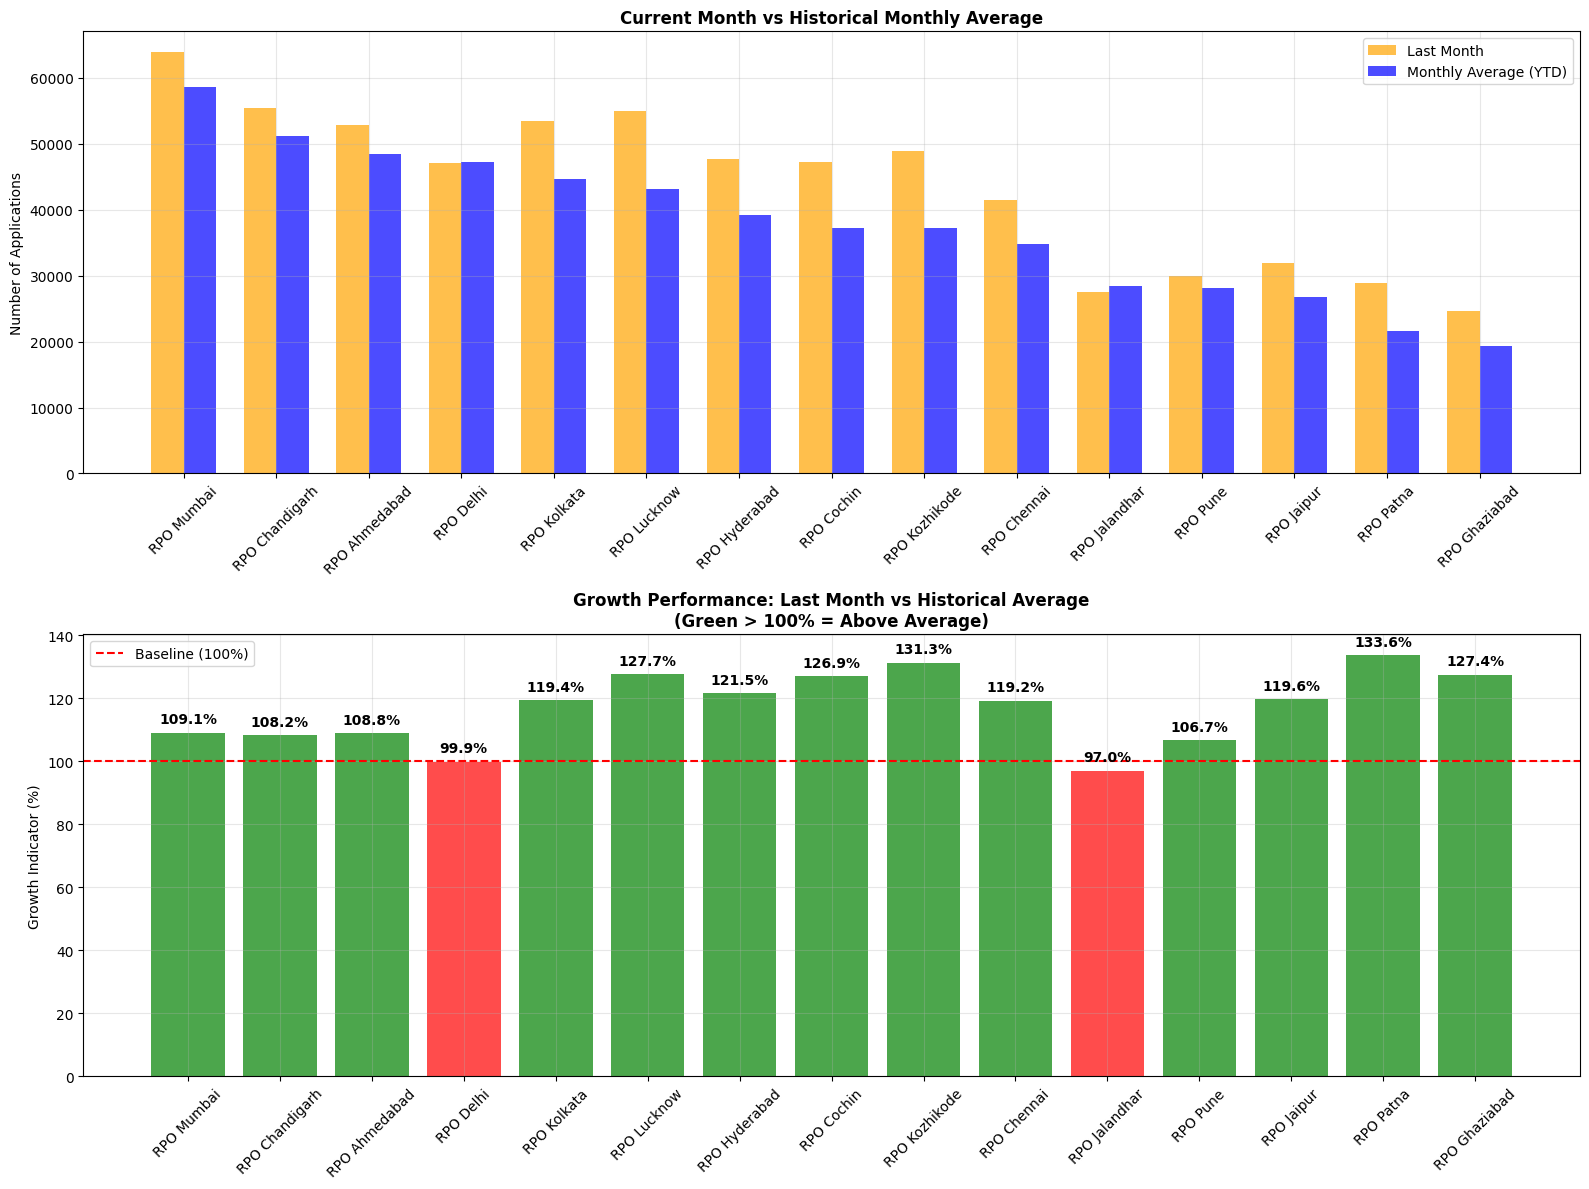

In [18]:
trend_comparison = df.filter(col("ServiceName") == "Applications Received - Scheme wise") \
    .groupBy("RpoName") \
    .agg(
        sum("LastMonthCount").alias("LastMonth"),
        sum("YearTillDate").alias("YTD")
    ) \
    .withColumn("MonthlyShare", (col("LastMonth") / col("YTD") * 100)) \
    .orderBy(desc("YTD")) \
    .limit(15)

trend_pd = spark_to_pandas(trend_comparison)

trend_pd['GrowthIndicator'] = trend_pd['LastMonth'] / (trend_pd['YTD'] / 12) * 100  # vs monthly average

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

x = np.arange(len(trend_pd['RpoName']))
width = 0.35

ax1.bar(x - width/2, trend_pd['LastMonth'], width, label='Last Month', alpha=0.7, color='orange')
ax1.bar(x + width/2, trend_pd['YTD']/12, width, label='Monthly Average (YTD)', alpha=0.7, color='blue')
ax1.set_ylabel('Number of Applications')
ax1.set_title('Current Month vs Historical Monthly Average', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(trend_pd['RpoName'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

colors = ['green' if x > 100 else 'red' for x in trend_pd['GrowthIndicator']]
bars = ax2.bar(trend_pd['RpoName'], trend_pd['GrowthIndicator'], color=colors, alpha=0.7)
ax2.axhline(y=100, color='red', linestyle='--', label='Baseline (100%)')
ax2.set_ylabel('Growth Indicator (%)')
ax2.set_title('Growth Performance: Last Month vs Historical Average\n(Green > 100% = Above Average)', fontweight='bold')
ax2.set_xticklabels(trend_pd['RpoName'], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

for bar, value in zip(bars, trend_pd['GrowthIndicator']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{value:.1f}%', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [102]:
from pyspark.sql.functions import when

df_scheme = df.filter((col("ServiceName").contains("Scheme wise")) | (col("ServiceName").contains("Gender wise")))

df_summary = df_scheme.groupBy("ServiceName") \
    .agg(sum("YearTillDate").alias("Total_Applications"))

df_summary.show(truncate=False)


scheme_total = df_summary.filter(col("ServiceName").contains("Scheme wise")).collect()[0][1]
gender_total = df_summary.filter(col("ServiceName").contains("Gender wise")).collect()[0][1]

diff = scheme_total - gender_total


if scheme_total == gender_total:
    print(f"Both 'Scheme wise' and 'Gender wise' have the same number of applications: {scheme_total}")
else:
    print("Total numer of Applications by TRANSGERNDER is: ",diff)

+-----------------------------------+------------------+
|ServiceName                        |Total_Applications|
+-----------------------------------+------------------+
|Applications Received - Gender wise|9046710           |
|Applications Received - Scheme wise|9047386           |
+-----------------------------------+------------------+

Total numer of Applications by TRANSGERNDER is:  676


In [122]:
print("=== Educated female applicants from Hyderabad to other cities ===")

education_female_df = df.filter(
    (df.ServiceName == "Applications - Education Wise") &
    (df.SchemeType.isin("10TH PASS AND ABOVE", "GRADUATE AND ABOVE")) &
    (df.RpoName == "RPO Hyderabad")
)

education_female_df.groupBy("RpoName", "SchemeType") \
    .agg(sum("YearTillDate").alias("Total_Female_Applicants")) \
    .show()

=== Educated female applicants from Hyderabad to other cities ===
+-------------+-------------------+-----------------------+
|      RpoName|         SchemeType|Total_Female_Applicants|
+-------------+-------------------+-----------------------+
|RPO Hyderabad| GRADUATE AND ABOVE|                 157847|
|RPO Hyderabad|10TH PASS AND ABOVE|                 152407|
+-------------+-------------------+-----------------------+



In [124]:
print("Application processing time")

df.filter(df.ServiceName == "PV Processing Time") \
  .groupBy("SchemeType") \
  .agg(sum("YearTillDate").alias("Applications")) \
  .show()


Application processing time
+-----------------+------------+
|       SchemeType|Applications|
+-----------------+------------+
|More than 21 Days|     1049175|
|   Within 21 Days|     5412490|
+-----------------+------------+



In [16]:
print("Increase in the Adoption of Aadhaar-Linked applications over time")

from pyspark.sql.functions import year, to_date

aadhaar_df = df.filter(df.ServiceName == "Applications with Aadhaar Number") \
               .withColumn("Year", year(to_date("Date")))
aadhaar_df.groupBy("Year").agg(sum("YearTillDate").alias("Total_Aadhaar_Applications")) \
      .orderBy("Year", ascending=True) \
    .show()


Increase in the Adoption of Aadhaar-Linked applications over time
+----+--------------------------+
|Year|Total_Aadhaar_Applications|
+----+--------------------------+
|2016|                    181961|
|2019|                   8864749|
+----+--------------------------+



In [17]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col, round, sum as spark_sum

aadhaar_yearly = aadhaar_df.groupBy("Year") \
    .agg(spark_sum("YearTillDate").alias("Total_Aadhaar_Applications")) \
    .orderBy("Year")

windowSpec = Window.orderBy("Year")

aadhaar_pct = aadhaar_yearly.withColumn(
    "Percentage_Increase",
    round(((col("Total_Aadhaar_Applications") - lag("Total_Aadhaar_Applications").over(windowSpec))
           / lag("Total_Aadhaar_Applications").over(windowSpec)) * 100, 2)
)

aadhaar_pct.select("Year", "Percentage_Increase").show()
print("There is a 4771.79% increase in adoption of aadhaar linked applications ")

+----+-------------------+
|Year|Percentage_Increase|
+----+-------------------+
|2016|               NULL|
|2019|            4771.79|
+----+-------------------+

There is a 4771.79% increase in adoption of aadhaar linked applications 
